<a href="https://colab.research.google.com/github/AgneseRe/Benchmarking-Open-MLLMs/blob/main/ResultsOpenMLLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarking Results Open-Source Multimodal Large Language Models (MLLMs)

<a target="_blank" href="https://colab.research.google.com/drive/1XmAS4ylKuMcjWOHTNY_q-okv0zDhmulJ"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Environment setup

In [1]:
!rm -r sample_data/

In [ ]:
!pip install adjustText

In [79]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, os, re, tabulate, time

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, Tuple
from adjustText import adjust_text
from matplotlib.lines import Line2D
from sklearn.metrics import precision_recall_fscore_support

In [3]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Download dataset

Download the Odd-One-Out ($O^3$) dataset. The width and height of all images fall in (498, 1024) and (334, 1024) respectively.

In [4]:
# download and unzip O3 (Colab commands. In VSCode in terminal)
if not os.path.isdir(f'{HOME}/O3_data'):
  print('Downloading O3 data using gdown...')
  !gdown -q 'https://drive.google.com/uc?id=1YQv836zhA0g-1vwRIeLMIWtqXrHGfH0d'
  !unzip -q 'O3_data.zip'
  !rm 'O3_data.zip'
  print('O3 downloaded with success.')
else:
  print('O3 data already downloaded.')

O3 downloaded with success.


In [5]:
image_prop_df = pd.read_csv(f"{HOME}/O3_data/image_properties.csv", sep=";")

## Download true and predicted markers

In [6]:
if not os.path.isdir(f'{HOME}/O3_output/som'):
  print('Downloading SoM images using gdown...')
  %cd {HOME}
  !gdown -q 'https://drive.google.com/uc?id=1vTQThhgXriGmfI_7TKFhPXX_CfHq5w88' -O som.zip
  !unzip -q 'som.zip'
  !rm 'som.zip'
  print('SoM images downloaded with success.')
else:
  print('SoM images already downloaded.')

/content
SoM images downloaded with success.


In [8]:
SOM_DIR = f'{HOME}/som'
os.makedirs(SOM_DIR, exist_ok=True)

Initialize mapping between the evaluated Multimodal Large Language Models (MLLMs) and their respective result files on Google Drive.

In [7]:
data_config = {
    "InternVL3-1B" : {
        "class_name" : {
            "no_cot" : "1nDpDtdRYMtg_TVQNqlJjHUXTWSL36AjG",
            "with_cot" : "1MIKsAhcVmlGpodvc9G5pam2ry2u_zsjZ"
        },
        "no_class_name" : {
            "no_cot" : "1QD50UvVfKRWlzuiWomW-7XeGZ91fMSrc",
            "with_cot" : "1DrXi7Pz6w0xRcEyMtgeEAyZv27FyjWbs"
        }
    },
    "InternVL3-2B" : {
        "class_name" : {
            "no_cot" : "1ZKHUjOYLDjwNenqhICM2FukKEGOaZLi3",
            "with_cot" : "1qBdBEAs5Q5f5NDqhTpcFBTZJva3h1sxr"
        },
        "no_class_name" : {
            "no_cot" : "1Ks7MHB5Oh8-W9Myo0fnM6hxeEocjCeZh",
            "with_cot" : "1ZOEa8umkJA0KR1q-oxTA9Kb8N_VOajGa"
        }
    },
    "InternVL3-8B" : {
        "class_name" : {
            "no_cot" : "1Z9l0rSg2IPGMP2FPeorHF2-htXEyTnOq",
            "with_cot" : "1XU-eA1ltabiKTr2mCOgGp5rZfWfYCxqp"
        },
        "no_class_name" : {
            "no_cot" : "1mIDCUKsmcs3YJfyBVmMBpUG_M3ZdvVze",
            "with_cot" : "1BF4nlbT0_it1Us5wh5IaayYVEA3kDqYr"
        }
    },
    "InternVL3-14B" : {
        "class_name" : {
            "no_cot" : "1f6QV8wlll-FG7DjxMHIYJk9yDJaBBP4s",
            "with_cot" : "1b8LBc-mzDpkwPaRbwW5QR-DMG3cs_IPQ"
        },
        "no_class_name" : {
            "no_cot" : "1bJjdTSXHCCGCKRsHthUvYLzjkBecx0Lw",
            "with_cot" : "14F1aar5vNGkEPhZfZmYo3K-dwltJK7BT"
        }
    },
    "InternVL3_5-8B" : {
        "class_name" : {
            "no_cot" : "1nuxY0Z7yuYQcWgSCqew8LKTIay3CQ0so",
            "with_cot" : "1qFfmM6eUs0rRsWOXZm1rDInDSJM7telj"
        },
        "no_class_name" : {
            "no_cot" : "1ZHthPsT2D28Z1GpRiGhdFYyf89jy9fz5",
            "with_cot" : "1LMMuCm2GIWQ6woqoINuJ4FWD4pOajfkm"
        }
    },
    "InternVL3_5-38B" : {
        "class_name" : {
            "no_cot" : "1qVD3lOM9RFKyxez1fejqvUMRYsoDSJ-_",
            "with_cot" : "19g7yx0t5YzAkhprLA_uJn69EGLFCgre0"
        },
        "no_class_name" : {
            "no_cot" : "1a4iD1j45Di6717N_yJXtt9pVgCAXZnhv",
            "with_cot" : "1BKFwqeq9mUgs2lQGQiE_ad3ThgPu2BYj"
        }
    },
    "llava-onevision-qwen2-0.5b-ov" : {
        "class_name" : {
            "no_cot" : "1g8LxRmrtSdG2e3miebAVabjBdprggOP4",
            "with_cot" : "1N84gFTG1J4kMT2GvhWG5HqSPfmukQQXi"
        },
        "no_class_name" : {
            "no_cot" : "1XVvmDmXPtLgsxdhV0Nv0Um-1Lcsak5Xh",
            "with_cot" : "1ahvu5G1aLTn3lsI0rr7cw1ID47Al8XCk"
        }
    },
    "llava-onevision-qwen2-7b-ov" : {
        "class_name" : {
            "no_cot" : "1U4t66Wl2v8O71Ha1EhiSPdW11KC2dU7q",
            "with_cot" : "19edW2a_W8XBKk0ED_2LI3qWd3jLikNH7"
        },
        "no_class_name" : {
            "no_cot" : "1EVi3HTvlS48pwKgYZEqUzHvHglx0pxX1",
            "with_cot" : "1N9Jbr2SfoF-d51aT0dQVg2qYEwKjwlHx"
        }
    },
    "llava-onevision-qwen2-72b-ov" : {
        "class_name" : {
            "no_cot" : "10Py95bkLHBkQ9VVRa4TjHhycjyIL6VKj",
            "with_cot" : "1zo-n4JZKk3r4v40uIOkUbN6UqovmRdI1"
        },
        "no_class_name" : {
            "no_cot" : "1IeaxQ2KVk2d_ZQqA8VxqTqse5UCTYqi3",
            "with_cot" : "1IcIpVVEIG7nTkubx7WU4ZxNvCXIEbuds"
        }
    },
    "MiniCPM-V-4" : {
        "class_name" : {
            "no_cot" : "1TU4bBvtVYI-bYEEdUw3xYMmJd10s7WQB",
            "with_cot" : "1v-q3pyB60_IBVqWhemQpgmaEh11eFM0z"
        },
        "no_class_name" : {
            "no_cot" : "1ZpRPmBefahywN-uXkc5j8p_VGTf6HEbO",
            "with_cot" : "1Sgh2mSI8v6cKVPK4cfdfP__fzcnT9nAj"
        }
    },
    "MiniCPM-V-4_5" : {
        "class_name" : {
            "no_cot" : "1X4B0-ACrbvn5MrXbFkmhwqj58GflXxto",
            "with_cot" : "1pJtjLktu4wKA-WM3vtpRCkDi-XiXK3Ew"
        },
        "no_class_name" : {
            "no_cot" : "1rYgLNejQ39ZPCfIgnJQqEZYkkL31s0yo",
            "with_cot" : "1BfJh_CYazVhcaiFox5TUooJac1lUF_KB"
        }
    },
    "Qwen2.5-VL-3B-Instruct" : {
        "class_name" : {
            "no_cot" : "1i4urcgMtUjmdv6Ke6N6XNtg2KGwKTa5o",
            "with_cot" : "1iu7e5aPfszCsOvR3zKAgOhjCcdW45grp"
        },
        "no_class_name" : {
            "no_cot" : "1sFgFvW2-Jw_4K-3GLK4RIAZ6-FBnUvnw",
            "with_cot" : "1UJNR86uH9Q8rKUv0Yc74ghpbHty2uGYy"
        }
    },
    "Qwen2.5-VL-7B-Instruct" : {
        "class_name" : {
            "no_cot" : "1i8Ueg1Oa21r6BsgIR68rGRogBhX8AFWK",
            "with_cot" : "19gf_KhH2n0WGgG8y6273t-pn8TyfRCuI"
        },
        "no_class_name" : {
            "no_cot" : "1uhg4jnWoV5B7UqUIqBT0e--gaFgTe3a5",
            "with_cot" : "18jMiSMyc7YIwqyiJMpup7A7JxBy-DGqf"
        }
    },
    "Qwen2.5-VL-32B-Instruct" : {
        "class_name" : {
            "no_cot" : "1dig7JD__2jRjpfsFKUoX6MafNH2tqY49",
            "with_cot" : "1cSBfNrvuBwJnB0DFxTyqfK_6KhovgZ05"
        },
        "no_class_name" : {
            "no_cot" : "1id6IwbLi4D7hwQ5VeWq7F6hFsdnhRvvd",
            "with_cot" : "11aJ8uYzKuwEX2uTPAkIi_tZQsWw2YxLi"
        }
    },
    "Qwen3-VL-4B-Instruct" : {
        "class_name" : {
            "no_cot" : "1SgVj-9flgNmtN-N9xCMX5NV0wNzrMYKs",
            "with_cot" : "19wEajs3VaSErx0v-zxHI2B7-ImHHgpmi"
        },
        "no_class_name" : {
            "no_cot" : "1QexoiKTzXCCKMaK74dsZyhxqDAbyREQO",
            "with_cot" : "19A5tjYAnsDtoWivFO9gZ4LUiDV8K2TUF"
        }
    },
  }

In [9]:
MODEL_NAMES = [
    "InternVL3-1B",
    "InternVL3-2B",
    "InternVL3-8B",
    "InternVL3-14B",
    "InternVL3_5-8B",
    "InternVL3_5-38B",
    "llava-onevision-qwen2-0.5b-ov",
    "llava-onevision-qwen2-7b-ov",
    "llava-onevision-qwen2-72b-ov",
    "MiniCPM-V-4",
    "MiniCPM-V-4_5",
    "Qwen2.5-VL-3B-Instruct",
    "Qwen2.5-VL-7B-Instruct",
    "Qwen2.5-VL-32B-Instruct",
    "Qwen3-VL-4B-Instruct"
]

In [10]:
CONFIGURATIONS = ["no_class_name no_cot", "no_class_name with_cot", "class_name no_cot", "class_name with_cot"]

In [11]:
%cd {HOME}

/content


In [12]:
print('Downloading model predictions using gdown...')
for MODEL_NAME in MODEL_NAMES:
  print(f"\n=========== {MODEL_NAME} ===========")
  for config in CONFIGURATIONS:
    class_type, cot_type = config.split()
    file_id = data_config[MODEL_NAME][class_type][cot_type]
    output_file_name = f"{MODEL_NAME}_{class_type}_{cot_type}_results.csv"
    !gdown -q 'https://drive.google.com/uc?id={file_id}' -O {output_file_name}
    print(f"{MODEL_NAME}_{class_type}_{cot_type}_results.csv downloaded with success.")


=========== InternVL3-1B ===========
InternVL3-1B_no_class_name_no_cot_results.csv downloaded with success.
InternVL3-1B_no_class_name_with_cot_results.csv downloaded with success.
InternVL3-1B_class_name_no_cot_results.csv downloaded with success.
InternVL3-1B_class_name_with_cot_results.csv downloaded with success.


=========== InternVL3-2B ===========
InternVL3-2B_no_class_name_no_cot_results.csv downloaded with success.
InternVL3-2B_no_class_name_with_cot_results.csv downloaded with success.
InternVL3-2B_class_name_no_cot_results.csv downloaded with success.
InternVL3-2B_class_name_with_cot_results.csv downloaded with success.


=========== InternVL3-8B ===========
InternVL3-8B_no_class_name_no_cot_results.csv downloaded with success.
InternVL3-8B_no_class_name_with_cot_results.csv downloaded with success.
InternVL3-8B_class_name_no_cot_results.csv downloaded with success.
InternVL3-8B_class_name_with_cot_results.csv downloaded with success.


=========== InternVL3-14B ==========

## Compute metrics utilities

In [13]:
def merge_df(image_properties_df: pd.DataFrame, wrong_predictions_df: pd.DataFrame) -> pd.DataFrame:
  wrong_predictions_df['image_name'] = wrong_predictions_df['image_name'] + ".jpg"  # image_name without extension
  merged_df = wrong_predictions_df.merge(image_properties_df, on='image_name', how='left')

  merged_df.rename(columns={'target_type_x': 'target_type'}, inplace=True)
  merged_df.drop(columns='target_type_y', inplace=True)

  return merged_df

In [14]:
def compute_metrics(results_csv_path: str):

  def _compute_errors_per_class(df: pd.DataFrame) -> Dict:
    errors_per_class = {}
    for _, row in df.iterrows():
      target_type = row['target_type']
      if target_type in errors_per_class:
        errors_per_class[target_type] += 1
      else:
        errors_per_class[target_type] = 1
    return errors_per_class

  def _compute_errors_per_feature(df: pd.DataFrame) -> Dict:
    FEATURE_DIMENSIONS = ['orientation', 'color', 'focus', 'shape',
                          'size', 'location', 'pattern']
    errors_per_feature_dim = {}
    for _, row in df.iterrows():
      for dim in FEATURE_DIMENSIONS:
        if row[dim] == 1:
          if dim in errors_per_feature_dim:
            errors_per_feature_dim[dim] += 1
          else:
            errors_per_feature_dim[dim] = 1
    return errors_per_feature_dim

  results_df = pd.read_csv(results_csv_path)
  wrong_predictions_df = results_df[~results_df['correct']].copy()

  total_predictions = len(results_df)
  correct_predictions = results_df['correct'].sum()

  # Accuracy + Precision, Recall, F1 score (macro and weighted)
  print("========== EVALUATION METRICS ==========")

  accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
  avg_tokens = results_df['tokens_used'].mean()

  print(f"Average Tokens Used: {avg_tokens:.2f}")
  print(f"Accuracy: {accuracy:.2f}% ({correct_predictions} correct predictions out of {total_predictions})")

  valid_results = results_df[results_df['predicted_odd_marker'].notna()].copy()
  valid_results['predicted_odd_marker'] = valid_results['predicted_odd_marker'].astype(int)
  valid_results['actual_odd_marker'] = valid_results['actual_odd_marker'].astype(int)

  if len(valid_results) > 0:
    y_true = valid_results['actual_odd_marker'].values
    y_pred = valid_results['predicted_odd_marker'].values

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    print("\nMacro Metrics (NOT account for label imbalance)")
    print(f"Precision: {precision_macro:.4f}")
    print(f"Recall: {recall_macro:.4f}")
    print(f"F1-Score: {f1_macro:.4f}")

    print("\nWeighted Metrics (account for label imbalance)")
    print(f"Precision: {precision_weighted:.4f}")
    print(f"Recall: {recall_weighted:.4f}")
    print(f"F1-Score: {f1_weighted:.4f}")

  print("\n========== ERRORS PER CLASS (TOP 10) ==========")
  print("The 'error_ratio (%)' refers only to the images on which the model fails.")
  print("The 'error_ratio_all (%)' refers to the total images on which the model is tested.")

  merged_df = merge_df(image_prop_df, wrong_predictions_df) # for error_ratio
  kept_df = pd.read_csv(f"{HOME}/som/odd_markers.csv") # for error_ratio_all (V.I. kept_df paths with prefix /content)
  image_prop_df['image_path'] = image_prop_df['image_name'].apply(lambda x: f"/content/O3_data/images/{x}")
  merged_df_all = kept_df.merge(image_prop_df, on='image_path', how='left')
  merged_df_all.rename(columns={'target_type_x': 'target_type'}, inplace=True)
  merged_df_all.drop(columns='target_type_y', inplace=True)
  merged_df_all.drop(columns='image_name', inplace=True)

  errors_per_class = _compute_errors_per_class(wrong_predictions_df)
  errors_per_class_all = _compute_errors_per_class(merged_df_all)

  sorted_classes = sorted(errors_per_class.items(), key=lambda item: item[1], reverse=True)
  table_classes = []
  for class_name, no_errors in sorted_classes:
    percentage = (no_errors / len(merged_df)) * 100
    percentage_all = (no_errors / errors_per_class_all[class_name]) * 100
    table_classes.append([class_name, no_errors, percentage, percentage_all])

  print(tabulate.tabulate(table_classes[:10], headers=['target_type', 'no_errors', 'error_ratio (%)',
                          'error_ratio_all (%)'], tablefmt="outline", floatfmt=".2f"))

  print("\n========== ERRORS PER FEATURE DIMENSION ==========")
  print("The odd object can differ for more than one feature")
  errors_per_feature_dim = _compute_errors_per_feature(merged_df)
  errors_per_feature_dim_all = _compute_errors_per_feature(merged_df_all)

  sorted_features = sorted(errors_per_feature_dim.items(), key=lambda item: item[1], reverse=True)
  table_features = []
  for feature, no_errors in sorted_features:
    percentage = (no_errors / len(merged_df)) * 100
    percentage_all = (no_errors / errors_per_feature_dim_all[feature]) * 100
    table_features.append([feature, no_errors, percentage, percentage_all])

  print(tabulate.tabulate(table_features, headers=['feature', 'no_errors', 'error_ratio (%)',
                          'error_ratio_all (%)'], tablefmt="outline", floatfmt=".2f"))

  return wrong_predictions_df  # only for 'Failure Considerations' section

## Results

In [15]:
wrong_predictions_df = compute_metrics('Qwen2.5-VL-7B-Instruct_class_name_no_cot_results.csv')

========== EVALUATION METRICS ==========
Average Tokens Used: 8.34
Accuracy: 77.26% (1240 correct predictions out of 1605)

Macro Metrics (NOT account for label imbalance)
Precision: 0.4097
Recall: 0.5144
F1-Score: 0.4372

Weighted Metrics (account for label imbalance)
Precision: 0.8205
Recall: 0.7726
F1-Score: 0.7894

========== ERRORS PER CLASS (TOP 10) ==========
The 'error_ratio (%)' refers only to the images on which the model fails.
The 'error_ratio_all (%)' refers to the total images on which the model is tested.
+---------------+-------------+-------------------+-----------------------+
| target_type   |   no_errors |   error_ratio (%) |   error_ratio_all (%) |
+===============+=============+===================+=======================+
| light         |          19 |              5.21 |                 52.78 |
| flower        |          17 |              4.66 |                 16.83 |
| tile          |          14 |              3.84 |                 42.42 |
| candy         | 

## Failure Considerations

In [ ]:
start_index = 0
end_index = 104 # 104 wrong predictions for Gemini

images_to_show = wrong_predictions_df.iloc[start_index:end_index]
num_images = len(images_to_show)

if num_images == 0:
    print(f"No images to visualize in batch ({start_index} - {end_index})")
else:
    cols = 3
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(15, 4.5 * rows))

    for i, row in images_to_show.reset_index(drop=True).iterrows():
        subplot_index = i + 1

        try:
            filename = row['image_name'].replace("jpg", "png")
            image_path = os.path.join(SOM_DIR, filename)
            som_image = Image.open(image_path)

            plt.subplot(rows, cols, subplot_index)
            plt.imshow(som_image)

            title = f"Actual: {row['actual_odd_marker']} | Pred: {row['predicted_odd_marker']}"
            plt.title(title, fontsize=8)
            plt.axis('off')
        except:
            continue # skip image

    plt.tight_layout()
    plt.show()

## Results

In [16]:
model_info = {
    "InternVL3-1B": ('InternVL3', 0.9),
    "InternVL3-2B": ('InternVL3', 2.0),
    "InternVL3-8B": ('InternVL3', 8.0),
    "InternVL3-14B": ('InternVL3', 15.0),
    "InternVL3_5-8B": ('InternVL3_5', 9.0),
    "InternVL3_5-38B": ('InternVL3_5', 38.0),
    "llava-onevision-qwen2-0.5b-ov": ('LLaVA-OneVision', 0.9),
    "llava-onevision-qwen2-7b-ov": ('LLaVA-OneVision', 8.0),
    "llava-onevision-qwen2-72b-ov": ('LLaVA-OneVision', 73.0),
    "MiniCPM-V-4": ('MiniCPM-V-4', 4.0),
    "MiniCPM-V-4_5": ('MiniCPM-V-4_5', 9.0),
    "Qwen2.5-VL-3B-Instruct": ('Qwen2.5-VL', 4.0),
    "Qwen2.5-VL-7B-Instruct": ('Qwen2.5-VL', 8.0),
    "Qwen2.5-VL-32B-Instruct": ('Qwen2.5-VL', 33.0),
    "Qwen3-VL-4B-Instruct": ('Qwen3-VL', 4.0),
}

In [17]:
# Summary dataframe
summary_data = []

for model_name, scenarios in data_config.items():
    family, size = model_info.get(model_name, ("Unknown", 0))

    configs_to_track = [
        ('no_class_name', 'no_cot', scenarios['no_class_name']['no_cot']),
        ('no_class_name', 'with_cot', scenarios['no_class_name']['no_cot']),
        ('class_name', 'no_cot', scenarios['class_name']['no_cot']),
        ('class_name', 'with_cot', scenarios['class_name']['with_cot']),
    ]

    for class_type, cot_type, file_id in configs_to_track:
        file_path = f"{model_name}_{class_type}_{cot_type}_results.csv"

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            accuracy = df['correct'].mean() * 100
            tokens_used = df['tokens_used'].mean()

            summary_data.append({
                'Model': model_name,
                'Family': family,
                'Size (B)': size,
                'Class Type': class_type,
                'CoT Type': cot_type,
                'Accuracy (%)': accuracy,
                'Avg Tokens': tokens_used
            })

df_summary = pd.DataFrame(summary_data)

In [96]:
def plot_scaling(df, configuration):
    subset = df[(df['Class Type'] == configuration[0]) & (df['CoT Type'] == configuration[1])].copy()
    if subset.empty:
        return

    plt.figure(figsize=(10, 7), dpi=100)

    families = subset['Family'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(families)))
    family_colors = dict(zip(families, colors))

    for family, data in subset.groupby('Family'):
        data = data.sort_values('Size (B)')

        # line only if more than one model per family
        lw = 1 if len(data) > 1 else 0

        plt.plot(data['Size (B)'], data['Accuracy (%)'],
                 marker='o', markersize=9, linewidth=lw,
                 label=family, color=family_colors[family],
                 alpha=0.7, markeredgecolor='white', markeredgewidth=1)

        for i, (idx, row) in enumerate(data.iterrows()):
            if i == len(data) - 1:
                label = f"{row['Size (B)']}B"
                plt.annotate(label, (row['Size (B)'], row['Accuracy (%)']),
                             textcoords="offset points", xytext=(8, 0),
                             ha='left', va='center', fontsize=8,
                             color=family_colors[family])

    ax = plt.gca()
    ax.set_facecolor('#fdfdfd')
    plt.grid(True, which="both", ls="--", alpha=0.3, color='gray')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#333333')
    ax.spines['bottom'].set_color('#333333')

    # Titolo Accademico
    title_map = {
        ('no_class_name', 'no_cot'): "Base Multimodal Evaluation",
        ('no_class_name', 'with_cot'): "Chain-of-Thought Ehnanced Evaluation",
        ('class_name', 'no_cot'): "Class-Aware Evaluation",
        ('class_name', 'with_cot'): "Chain-of-Thought + Class-Aware Evaluation"
    }
    plt.title(f"Odd-One-Out Task\n{title_map.get(configuration)}",
              fontsize=15, loc='left', pad=25, color='#222222')

    plt.ylabel('Accuracy (%)', fontsize=12)

    plt.xticks(np.arange(0, 81, 10), fontsize=10)
    plt.xlim(-2, 82)
    plt.ylim(subset['Accuracy (%)'].min() - 8, 105)

    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []

    for handle, label in zip(handles, labels):
        if len(subset[subset['Family'] == label]) == 1:
            new_handle = Line2D([0], [0], marker='o', color=handle.get_color(),
                                linestyle='None', markersize=9,
                                markeredgecolor='white', markeredgewidth=1)
            new_handles.append(new_handle)
        else:
            new_handles.append(handle)

    plt.legend(handles=new_handles, labels=labels,
               loc='lower right', bbox_to_anchor=(0.98, 0.05), fontsize=10,
               frameon=True, facecolor='white', edgecolor='#cccccc',
               framealpha=0.95, shadow=False)

    plt.tight_layout()
    plt.savefig(f"scaling_chart_{configuration[0]}_{configuration[1]}.png", bbox_inches='tight')
    plt.show()

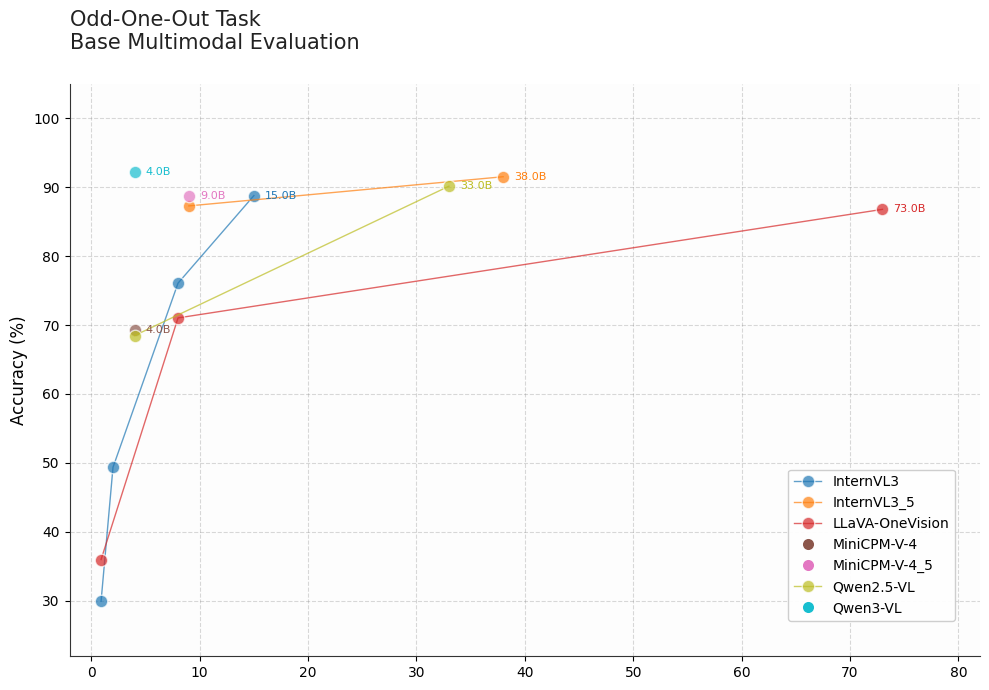

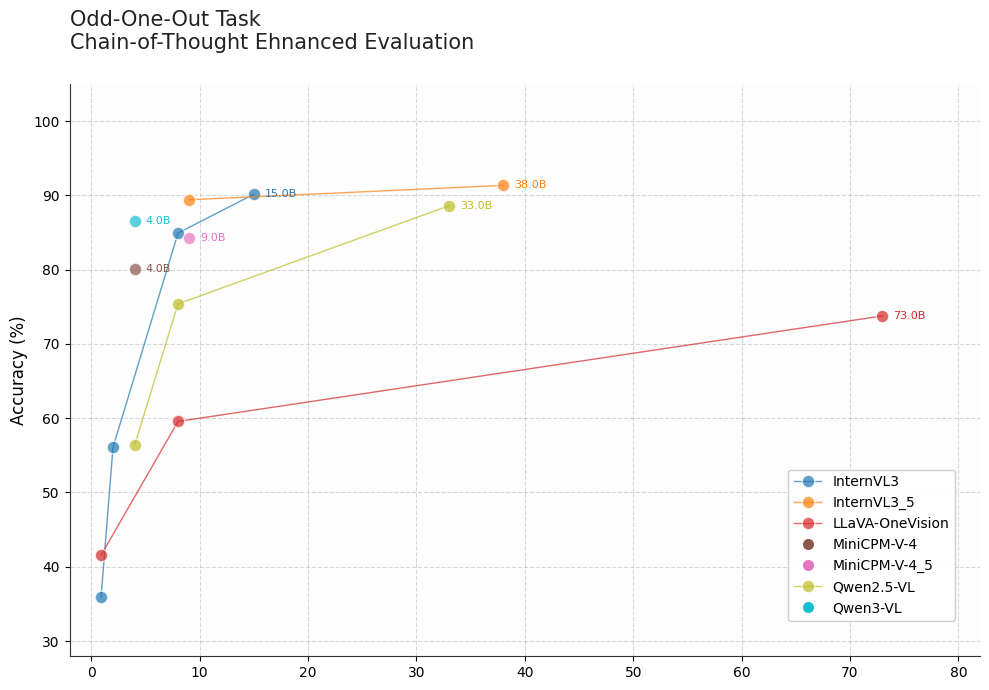

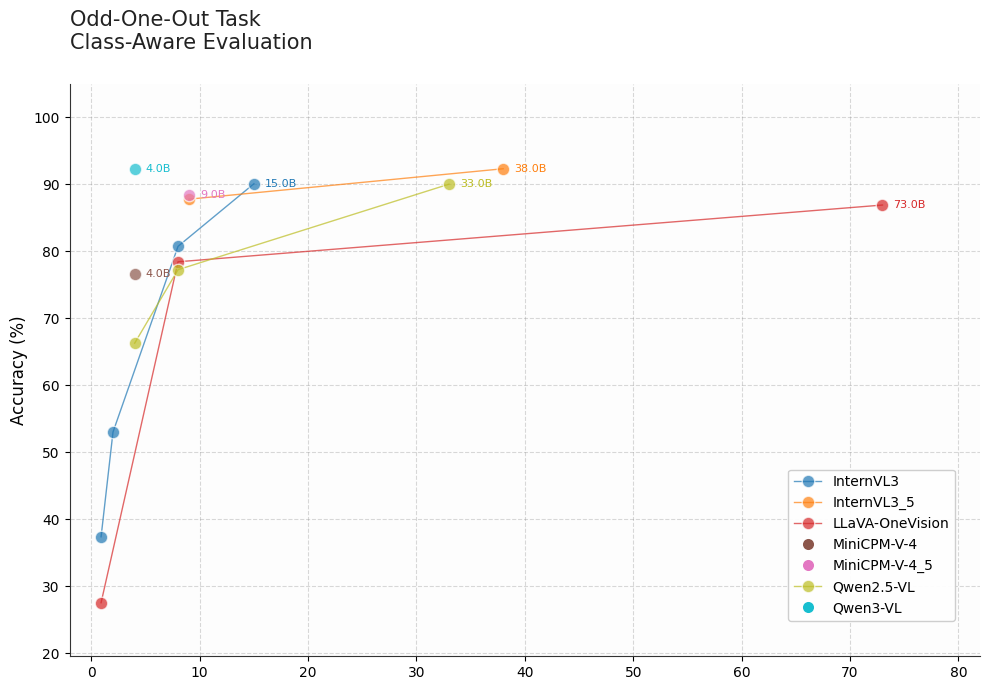

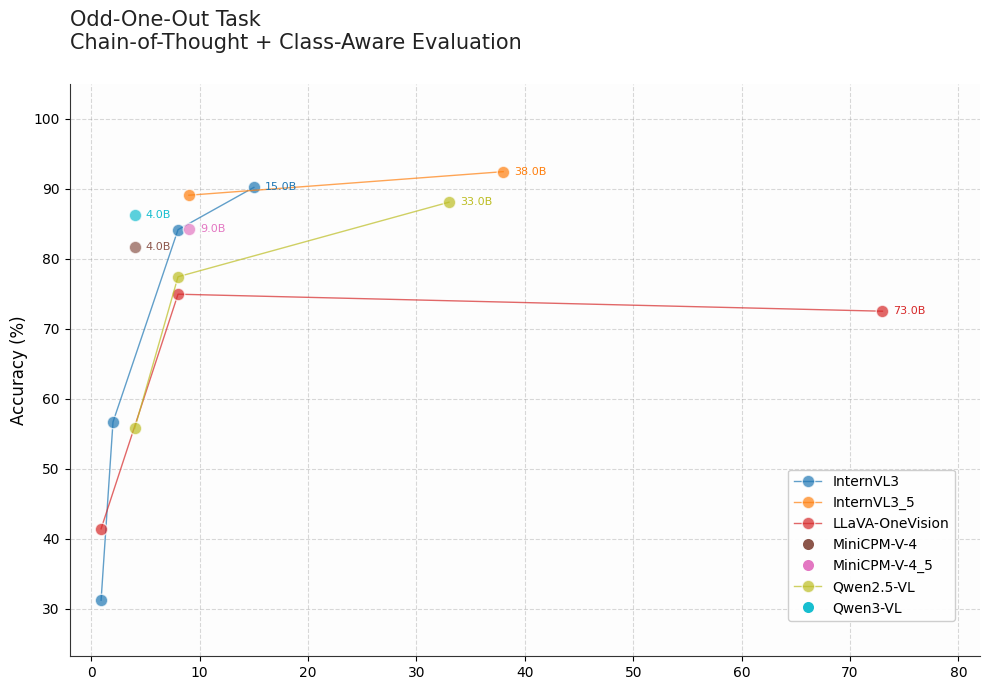

In [97]:
for configuration in [('no_class_name', 'no_cot'), ('no_class_name', 'with_cot'), ('class_name', 'no_cot'), ('class_name', 'with_cot')]:
    plot_scaling(df_summary, configuration)